In [32]:
import pandas as pd
import numpy as np
import csv
import os
from datetime import datetime
import matplotlib.pyplot as plt
import random
import seaborn as sns
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt

In [33]:
#Activate the first option if whole column width is necessary and the second to make all columns visible
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## I. Import the transformed datasets

In [34]:
#Get the three reports and store them into dataframes. Check what columns are included in the file
train = pd.read_csv('train_set_ph2.csv', index_col = 0)

print(train.columns)
print(train.shape)

Index(['feature_id', 'FinancialY', 'lane', 'avg_score_lane', 'sub_obs_val_max',
       'sub_obs_val_std', 'Carriageway Scheme', 'Drainage', 'Drainage CAT 2',
       'Localised Patching',
       ...
       'uvIndex__symmetry_looking__r_0.9500000000000001',
       'uvIndex__time_reversal_asymmetry_statistic__lag_1',
       'uvIndex__time_reversal_asymmetry_statistic__lag_2',
       'uvIndex__time_reversal_asymmetry_statistic__lag_3',
       'uvIndex__value_count__value_-1', 'uvIndex__value_count__value_0',
       'uvIndex__value_count__value_1', 'uvIndex__variance',
       'uvIndex__variance_larger_than_standard_deviation', 'runs'],
      dtype='object', length=5337)
(26766, 5337)


### I. Define the training set

In [35]:
train.head(10)

feature_id  FinancialY  lane  avg_score_lane  sub_obs_val_max  \
0    A10/104        2009  LEFT        3.940571            33.86   
1    A10/104        2010  LEFT        7.363529            80.00   
2    A10/104        2011  LEFT        2.392424            52.79   
3    A10/104        2012  LEFT        2.563235            27.62   
4    A10/104        2013  LEFT        9.592353            79.88   
5    A10/104        2015  LEFT        7.112727            60.00   
6    A10/104        2017  LEFT        5.139697            60.00   
7    A10/104        2018  LEFT        2.020313            19.99   
8    A10/104        2019  LEFT        7.849687            70.99   
9    A10/108        2009  LEFT        9.563737           107.29   

   sub_obs_val_std  Carriageway Scheme  Drainage  Drainage CAT 2  \
0         9.027565                 0.0       0.0             0.0   
1        15.936653                 0.0       0.0             0.0   
2         9.425704                 0.0       0.0             0.0   
3         6.486717                 0.0       0.0             0.0   
4        19.787100                 0.0       0.0             0.0   
5        15.221890                 0.0       0.0             0.0   
6        15.106133                 0.0       0.0             0.0   
7         5.132242                 0.0       0.0             0.0   
8        16.159381                 0.0       0.0             0.0   
9        21.105137                 0.0       0.0             0.0   

   Localised Patching  Long Term Structural Maintenance  Major Patching  \
0                 0.0                               0.0             0.0   
1                 0.0                               0.0             0.0   
2                 0.0                               0.0             0.0   
3                 0.0                               0.0             0.0   
4                 0.0                               0.0             0.0   
5                 0.0                               0.0             0.0   
6                 0.0                               0.0             0.0   
7                 0.0                               0.0             0.0   
8                 0.0                               0.0             0.0   
9                 0.0                               0.0             0.0   

   Microasphalt  Reconstruction  Recycling  Super Cat 2  Surface Dressing  \
0           0.0             0.0        0.0          0.0               0.0   
1           0.0             0.0        0.0          0.0               0.0   
2           0.0             0.0        0.0          0.0               0.0   
3           0.0             0.0        0.0          0.0               0.0   
4           0.0             0.0        0.0          0.0               0.0   
5           0.0             0.0        0.0          0.0               0.0   
6           0.0             0.0        0.0          0.0               0.0   
7           0.0             0.0        0.0          0.0               0.0   
8           0.0             0.0        0.0          0.0               0.0   
9           0.0             0.0        0.0          0.0               0.0   

   Surface Inlay  Surface Overlay  Surface Preservative  Thin Surfacing  \
0            0.0              0.0                   0.0             0.0   
1            0.0              0.0                   0.0             0.0   
2            0.0              0.0                   0.0             0.0   
3            0.0              0.0                   0.0             0.0   
4            0.0              0.0                   0.0             0.0   
5            0.0              0.0                   0.0             0.0   
6            0.0              0.0                   0.0             0.0   
7            0.0              0.0                   0.0             0.0   
8            0.0              0.0                   0.0             0.0   
9            0.0              0.0                   0.0             0.0   

   Years_since 

In [36]:
#Replace nulls in the Gritting and traffic columns  with 0 since no runs took place in that road that year.
train['runs'].fillna(0, inplace = True)
train['AADT_Comb'].fillna(0, inplace = True)

In [37]:
#LABEL ENCODING for categorical data:
train['hierarchy'] = train['hierarchy'].astype('category').cat.codes
train['road_type_hw'] = train['road_type_hw'].astype('category').cat.codes
train['urban_rural'] = train['urban_rural'].astype('category').cat.codes
train['surf_type'] = train['surf_type'].astype('category').cat.codes
train['SURF'] = train['SURF'].astype('category').cat.codes
train['BEDR'] = train['BEDR'].astype('category').cat.codes

In [38]:
#Drop the index columns:
train_set = train.drop(columns = ['feature_id', 'FinancialY', 'lane'])

In [43]:
train_set.head(5)

,avg_score_lane,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,Prev_RCI,AADT_Comb,cloudCover__abs_energy,cloudCover__absolute_sum_of_changes,"cloudCover__agg_autocorrelation__f_agg_""mean""__maxlag_40","cloudCover__agg_autocorrelation__f_agg_""median""__maxlag_40","cloudCover__agg_autocorrelation__f_agg_""var""__maxlag_40","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","cloudCover__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""","cloudCover__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""stderr""","cloudCover__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""","cloudCover__agg_linear_trend__f_agg_""var""__chunk_le

In [50]:
train_set2 = train_set.iloc[:,0:56]
runs = train_set.iloc[:,-1]
train_set_conc = pd.concat([train_set2, runs], axis=1)

In [51]:
train_set_conc.head(5)

,avg_score_lane,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,Prev_RCI,AADT_Comb,runs
0,3.940571,33.86,9.027565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,4,0.0,4,341.0,9,2,1,14.21,3.940571,12730.0,118.0
1,7.363529,80.00,15.936653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,4,0.0,4,341.0,9,2,1,14.21,3.940571,12730.0,132.0
2,2.392424,52.79,9.425704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,4,0.0,4,341.0,9,2,1,14.21,7.363529,12730.0,79.0
3,2.563235,27.62,6.486717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,4,0.0,4,341.0,9,2,1,14.21,2.392424,12730.0,76.0
4,9.592353,79.88,19.787100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,4,0.0,4,341.0,9,2,1,14.21,2.563235,12730.0,129.0


In [52]:
#Split dataframe in dependent and independent variables #REMOVE MAX and STD DEVIATION
x_set = train_set_conc.iloc[:, 3:]
y_set = train_set_conc.iloc[:, 0] #THE Y SET WILL BE THE AVG VALUE.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.2)

In [65]:
#Train the model with certain hyperparameters:
l_rate = [0.1,0.25,0.5,0.75,1]
for lr in l_rate:
    model = GradientBoostingRegressor(n_estimators=500, learning_rate=lr, 
                           max_features=5, max_depth=5)
    model.fit(X_train,y_train)
    
    print('For ' + str(lr) + ' the RMSE is: ')
    
       
    # predict the target on the train dataset
    predict_train = model.predict(X_train)
    #print('\nTarget on train data',predict_train) 

    # Root Mean Squared Error on train dataset
    rmse_train = sqrt(mean_squared_error(y_train,predict_train)) 
    print('\RMSE on train dataset : ', rmse_train)

    # predict the target on the test dataset
    predict_test = model.predict(X_test)
    #print('\nTarget on test data',predict_test) 

    # Accuracy Score on test dataset
    rmse_test = sqrt(mean_squared_error(y_test,predict_test))
    print('\RMSE on test dataset : ', rmse_test)
    
    score = model.score(X_train,y_train)
    print('\Model score : ', score)

For 0.1 the RMSE is: 
\RMSE on train dataset :  13.144430315461502
\RMSE on test dataset :  14.482583329528255
\Model score :  0.7089381272135499
For 0.25 the RMSE is: 
\RMSE on train dataset :  11.922750299524823
\RMSE on test dataset :  14.747682408742797
\Model score :  0.7605280339453123
For 0.5 the RMSE is: 
\RMSE on train dataset :  10.709273666598062
\RMSE on test dataset :  15.147079128193086
\Model score :  0.8067934630853204
For 0.75 the RMSE is: 
\RMSE on train dataset :  10.210733766605074
\RMSE on test dataset :  15.923672989697668
\Model score :  0.8243631304527769
For 1 the RMSE is: 
\RMSE on train dataset :  10.07865857873786
\RMSE on test dataset :  17.341313789491842
\Model score :  0.8288774475333556


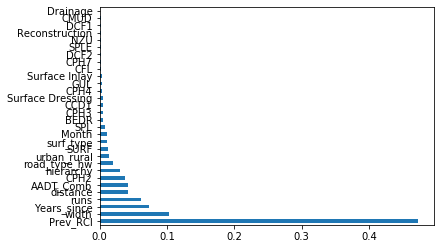

In [55]:
feat_importances = pd.Series(model.feature_importances_, index=x_set.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [60]:
X_test.columns

Index(['Carriageway Scheme', 'Drainage', 'Drainage CAT 2',
       'Localised Patching', 'Long Term Structural Maintenance',
       'Major Patching', 'Microasphalt', 'Reconstruction', 'Recycling',
       'Super Cat 2', 'Surface Dressing', 'Surface Inlay', 'Surface Overlay',
       'Surface Preservative', 'Thin Surfacing', 'Years_since', 'CCD1', 'CCD3',
       'CCD4', 'CFL', 'CFS1', 'CKD2', 'CKD3', 'CMD3', 'CMUD', 'CPH2', 'CPH3',
       'CPH4', 'CPH7', 'CSH1', 'DCF1', 'DCF2', 'DCF3', 'DPD1', 'DPD2', 'GUL',
       'NZU', 'PDAM', 'RICE', 'SFL', 'SPL', 'SPLE', 'SURF', 'BEDR', 'Month',
       'hierarchy', 'distance', 'road_type_hw', 'urban_rural', 'surf_type',
       'width', 'Prev_RCI', 'AADT_Comb', 'runs'],
      dtype='object')

In [57]:
len(predict_test)

5354